# Data Cleaning Notebook

This data set came from a Mexican Government [website](https://www.gob.mx/salud/documentos/datos-abiertos-152127). I found a link to this dataset in a [kaggle](https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset) project that somebody has done. I thought that finding COVID data would be easier than this, but it turns out that HIPPA laws do not allow data on the individual patient level to be made available to the public even if their names are left out. Therefore, only summary level data sets (like by county, or by age group) are able to be viewed by the public. This data set from the Mexican Government is at the individual patient level and doesn't provide any patient identification information.

In [50]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import utils

In [7]:
#cd ..

C:\Users\david\Desktop\UMBC\DATA602\Projects\Project_1


In [2]:
#import the data set
covid_data = pd.read_csv('Data/201001COVID19MEXICO.csv')

The original data set has 1,048,575 observations and 35 features. Also the column names are all in Spanish.

The kaggle project author has done translations of the feature descriptions so I will first create a dictionary containing all column names with the key being the Spanish, and the value being the English translation. Then I am going to change the column names to the English translations.

In [3]:
translation_dict = {
    'FECHA_ACTUALIZACION': 'Update Date',
    'ID_REGISTRO': 'Record ID',
    'ORIGEN':'Origin',
    'SECTOR': 'Sector',
    'ENTIDAD_UM':'Entity Location',
    'SEXO':'Sex',
    'ENTIDAD_NAC':'Entity of Birth',
    'ENTIDAD_RES':'Entity of Residence',
    'MUNICIPIO_RES':'Residence Municipality',
    'TIPO_PACIENTE':'Type of Care',
    'FECHA_INGRESO':'Admission Date',
    'FECHA_SINTOMAS':'Sympton Onset',
    'FECHA_DEF':'Date of Death',
    'INTUBADO':'Intubation Required',
    'NEUMONIA':'Pneumonia',
    'EDAD':'Age',
    'NACIONALIDAD':'Nationality',
    'EMBARAZO':'Pregnant',
    'HABLA_LENGUA_INDIG':'Speak Indigenous',
    'DIABETES':'Diabetes',
    'EPOC':'COPD Diagnosis',
    'ASMA':'Asthma',
    'INMUSUPR':'Immunosuppression',
    'HIPERTENSION':'Hypertension',
    'OTRA_COM':'Other Diseases',
    'CARDIOVASCULAR':'Cardiovascular Disease',
    'OBESIDAD':'Obesity',
    'RENAL_CRONICA':'Kidney Failure',
    'TABAQUISMO':'Smoker',
    'OTRO_CASO':'Contact',
    'RESULTADO':'Test Result',
    'MIGRANTE':'Migrant',
    'PAIS_NACIONALIDAD':'Prior Nationality',
    'PAIS_ORIGEN':'Prior Origin',
    'UCI':'Intensive Care Needed'
}

In [4]:
#now I'm going to change the names to be in English using the dictionary above
english_names = [translation_dict[x] for x in covid_data.columns]
covid_data.columns = english_names

# Value Mapping <br>
Most data fields in this data set have numeric representations for non-numeric values. For example, 1 refers to 'Ambulatory' in the 'Type of Care' field.

Below are dictionaries I have created using the 'Catalogos_0412.csv' file provided with the Covid data.

There are 36 entities, each associated with a number between 1 and 36. There are also values of 97,98, and 99 for 'Not Applicable', 'Ignored', and 'Not Specified', respectively.

In [5]:
#creating the number value array
entity_numbers1 = np.arange(1,37,1)
#I need to loop through this to cast them from int32 to int for compatability with writing to json file.
entity_numbers = []
for i in entity_numbers1:
    entity_numbers.append(int(i))
entity_numbers.append(97)
entity_numbers.append(98)
entity_numbers.append(99)

#now I need to create the list of the entity names
entity_names = ['AGUASCALIENTES','BAJA CALIFORNIA','BAJA CALIFORNIA SUR','CAMPECHE','COAHUILA DE ZARAGOZA','COLIMA','CHIAPAS',
'CHIHUAHUA','CIUDAD DE MÉXICO','DURANGO','GUANAJUATO','GUERRERO','HIDALGO','JALISCO','MÉXICO','MICHOACÁN DE OCAMPO',
'MORELOS','NAYARIT','NUEVO LEÓN','OAXACA','PUEBLA','QUERÉTARO','QUINTANA ROO','SAN LUIS POTOSÍ','SINALOA','SONORA',
'TABASCO','TAMAULIPAS','TLAXCALA','VERACRUZ DE IGNACIO DE LA LLAVE','YUCATÁN','ZACATECAS','ESTADOS UNIDOS MEXICANOS',
'Not Applicable','Ignored','Not Specified']

#creating the dictionary
entity_dict = dict(zip(entity_numbers,entity_names))

There are over 2,000 municipalities, so instead of manually typing them out, I'm importing the values from a csv file I created from copying and pasting the table of mappings from the main catalogueing file.

In [6]:
municipality_mapping = pd.read_csv('Data/Municipality_mapping.csv')
#the same number can be assigned to different municipalities, but each number is unique to the municipalities in each state
#so I am making a municipality_name list that will have the combination of the municipality number and entity number
municipality_combined_names = []
for i in range(len(municipality_mapping['CLAVE_MUNICIPIO'])):
    municipality_combined_names.append(str(municipality_mapping['CLAVE_MUNICIPIO'][i])+'_'+str(municipality_mapping['CLAVE_ENTIDAD'][i]))
municipality_dict = dict(zip(municipality_combined_names,municipality_mapping['MUNICIPIO']))

In [7]:
#all remaining dictionaries are simple to create
nationality_dict = dict(zip([1,2,99],['Mexican','Foreign','Not Specified']))
origin_dict = dict(zip(['USMER','FUERA DE USMER','NO ESPECIFICADO'],['Usmer','Not Usmer','Not Specified']))
yes_no_dict = dict(zip([1,2,97,98,99],['Yes','No','Not Applicable','Ignored','Not Specified']))

In [8]:
value_mapping_dict={
    'Update Date':{},
    'Record ID':{},
    'Origin':origin_dict,
    'Sector':dict(zip([1,2,3,4,5,6,7,8,9,10,11,12,13,99],['Red Cross','DIF','State','IMSS','IMSS-Wellness','ISSSTE','Municipal','PEMEX','Private','SEDENA','SEMAR','SSA','Academic','Not Specified'])),
    'Entity Location':entity_dict,
    'Sex':dict(zip([1,2,99],['Female','Male','Not Specified'])),
    'Entity of Birth':entity_dict,
    'Entity of Residence':entity_dict,
    'Residence Municipality':municipality_dict,
    'Type of Care':dict(zip([1,2,99],['Ambulatory','Hospitalized','Not Specified'])),
    'Admission Date':{},
    'Sympton Onset':{},
    'Date of Death':{},
    'Intubation Required':yes_no_dict,
    'Pneumonia':yes_no_dict,
    'Age':{},
    'Nationality':nationality_dict,
    'Pregnant':yes_no_dict,
    'Speak Indigenous':yes_no_dict,
    'Diabetes':yes_no_dict,
    'COPD Diagnosis':yes_no_dict,
    'Asthma':yes_no_dict,
    'Immunosuppression':yes_no_dict,
    'Hypertension':yes_no_dict,
    'Other Diseases':yes_no_dict,
    'Cardiovascular Disease':yes_no_dict,
    'Obesity':yes_no_dict,
    'Kidney Failure':yes_no_dict,
    'Smoker':yes_no_dict,
    'Contact':yes_no_dict,
    'Test Result':dict(zip([1,2,3],['Positive','Negative','Pending'])),
    'Migrant':yes_no_dict,
    'Prior Nationality':{},
    'Prior Origin':{},
    'Intensive Care Needed':yes_no_dict
}

In [9]:
#now that the mappings are all created, I would like to write them to a json file
with open('Data/data_mapping_raw_data.json', 'w') as json_file:
    json.dump(value_mapping_dict, json_file)

# Cleaning the Data

First, I am only interested in observations that actually tested positive for Covid19, so I will drop all rows where 'Test Result' is 2 (Negative) or 3 (Pending).

In [10]:
indeces_to_delete = []
for i in range(len(covid_data['Test Result'])):
    if covid_data['Test Result'][i] == 3:
        indeces_to_delete.append(i)
    elif covid_data['Test Result'][i] == 2:
        indeces_to_delete.append(i)
#now to drop the rows that didn't test positive for Covid, and then reset the index
covid_data = covid_data.drop(indeces_to_delete)
covid_data = covid_data.reset_index(drop=True)

I found that the mapping provided with the data set does not completely identify all combinations of municpalities within entity. Because of this, as well as there being over 2,000 municipalities, I have decided to get rid of this feature. I am confident that whatever information is lost from this deletion will be replaced from the 'Entity of Residence' feature which shows which state the patient lives in.

In [11]:
del covid_data['Residence Municipality']

At this point, there are ALOT of columns. I've gone through these columns and evaluated the quality of the data in them. By this, I mean I looked at how complete each column is in terms of how many N/A values are present.<br>
a. "Prior Origin" and "Migrant" features have over 700,000 N/A values each. After step 1 above, there are only 703,973 observations. Since 700,000 is over 90% of the observations, these two columns will be delete. <br>
b. "Contact" feature has over 1/7 of it's observations being N/A. This feature seems more helpful for a tracing project, and whether or not the person had come in contact with a COVID patient doesn't change the fact they have COVID. This feature will be deleted too. <br>
c. "Speak Indegenous" feature has over 22,000 N/A values. Also, this feature seems pretty useless because a virus doesn't care what language you speak. This feature will be deleted too.<br>

In [12]:
del covid_data['Migrant']
del covid_data['Prior Origin']
del covid_data['Contact']
del covid_data['Speak Indigenous']

Then there are some more complicated features: <br>
"Entity of Birth", "Diabetes", "COPD Diagnosis", "Asthma", "Immunosuppression", "Hypertension", "Other Diseases", "Cardiovascular Disease", "Obesity", "Kidney Failure", and "Smoker" features all have roughly 1,900-2,100 N/A values each. After finding out what the overlap is, there is a total of 7,185 rows where atleast one of the features are N/A. This is less than 1% of the total number of observations. Therefore, I think it should be ok to simply delete the observations where one or more of these features has N/A. Also, when considerig this, I saw that 6,008 of the observations impacted by this deletion are patient that didn't die. This shows that 83.6% of the patients deleted here didn't die. When looking at the data as a whole, 89.4% of the observations didn't die. Since 83.6% is relatively close to 89.4%, I don't think that deleting these 7,185 rows is deleting observations that offer something special to the data. Therefore, I will delete these occurences. <br>

In [13]:
vars_of_interest = ["Entity of Birth", "Diabetes", "COPD Diagnosis", "Asthma", "Immunosuppression", "Hypertension", 
                    "Other Diseases", "Cardiovascular Disease", "Obesity", "Kidney Failure", "Smoker"]
row_deletions = []
exclusion_values = [97,98,99]
for i in range(len(covid_data['Record ID'])):
    delete_row = False
    for var in vars_of_interest:
        if covid_data[var][i] in exclusion_values:
            delete_row = True
    if delete_row:
        row_deletions.append(i)

In [14]:
covid_data = covid_data.drop(row_deletions)
covid_data = covid_data.reset_index(drop=True)

After performing the above actions, there are 7 N/A values in the "Pneumonia" feature. 7 observations is incredibly small for this data set, so I will delete these observations.

In [15]:
pneumonia_delete_rows = list(covid_data[covid_data['Pneumonia']==99].index)

covid_data = covid_data.drop(pneumonia_delete_rows)
covid_data = covid_data.reset_index(drop=True)

"Pregnant" feature has 368,300 N/A values. Many of these are from patients being Male, which makes sense because men can't get pregnant. For these 365,860 observations that are Male, I will change the Pregnant feature to equal 2. For the remaining 2,440 N/A values, I will assign a 2 (for not pregnant) since out of the 335,673 women (not including the N/As), only 5,201 are pregnant. This means that for each N/A value, there is only a 1.55% chance that observation is pregnant. My approach is a "Majority takes all" approach of solving this N/A problem.

In [16]:
new_pregnant_column = []
for i in range(len(covid_data['Record ID'])):
    if covid_data['Pregnant'][i] in [97,98]:
        new_pregnant_column.append(2)
    else:
        new_pregnant_column.append(covid_data['Pregnant'][i])
covid_data['Pregnant'] = new_pregnant_column

The "ICU" and "Intubation" features have a lot of N/A values (over 75%). These features seems very important because they mean the patient is getting hit hard by the virus. Therefore, I'd like to do whatever possible to keep these in the data set. Only 2% of the observations required ICU and 4% required Intubation. The remaining observations are either recorded as either not needing it, or have a value corresponding to "Not Applicable", and small portion (~2/100 of a percent) have "Not Specified". Since I have a bias of knowing that most people do not require extreme measures such as intubation or ICU when they get COVID, I am guessing that the reason for so many "Not Applicable" values is that when someone comes to a hospital, they may not need ICU or Intubation right away, and maybe the paperwork records "Not Applicable" for these fields, and if they later need it, it may not get updated in the paperwork. This is only a guess though. I am going to replace all of the "Not Applicable" and "No Specified" values to "No" (2). 

In [17]:
ICU_replacement = []
Intubation_replacement = []
for i in range(len(covid_data['Record ID'])):
    if covid_data['Intensive Care Needed'][i] in [97,99]:
        ICU_replacement.append(2)
    else:
        ICU_replacement.append(covid_data['Intensive Care Needed'][i])
    if covid_data['Intubation Required'][i] in [97,99]:
        Intubation_replacement.append(2)
    else:
        Intubation_replacement.append(covid_data['Intubation Required'][i])

In [18]:
covid_data['Intensive Care Needed'] = ICU_replacement
covid_data['Intubation Required'] = Intubation_replacement

Whether or not a person died can be gathered from the 'Date of Death' variable. If the value is a date, then unfortunately that person died. However, if the value is '9999-99-99', then the person did not die. With this information, I'm going to create a binary variable called 'Died' which shows whether a patient died (1) or not (0). While I am looping through the data to create this new variable, I will overwrite the 'Date of Death' variable so that '9999-99-99' is recorded as np.nan.

In [19]:
died = []
death_date = []
for i in range(len(covid_data['Date of Death'])):
    if str(covid_data['Date of Death'][i]) == '9999-99-99':
        died.append(0)
        death_date.append(np.nan)
    else:
        died.append(1)
        death_date.append(covid_data['Date of Death'][i])
covid_data['Died'] = died
covid_data['Date of Death'] = death_date

In [20]:
del died
del death_date

I am going to change all of the yes or no variables so that 0 corresponds to No, 1 corresponds to Yes.

In [21]:
yes_no_variables = ['Intubation Required','Pneumonia','Pregnant','Diabetes','COPD Diagnosis',
'Asthma','Immunosuppression','Hypertension','Other Diseases','Cardiovascular Disease','Obesity','Kidney Failure',
'Smoker','Intensive Care Needed']

all_replacements = []
for var in yes_no_variables:
    #I've included this print statement so I can gauge how long is left for running this cell
    print(var)
    replacement_values = []
    for i in range(len(covid_data[var])):
        if covid_data[var][i] == 2:
            replacement_values.append(0)
        elif covid_data[var][i] == 1:
            replacement_values.append(1)
        else:
            replacement_values.append(np.nan)
    all_replacements.append(replacement_values)

Intubation Required
Pneumonia
Pregnant
Diabetes
COPD Diagnosis
Asthma
Immunosuppression
Hypertension
Other Diseases
Cardiovascular Disease
Obesity
Kidney Failure
Smoker
Intensive Care Needed


In [22]:
#now I will write these replacements into the dataframe to overwrite the original codings
for i in range(len(yes_no_variables)):
    covid_data[yes_no_variables[i]] = all_replacements[i]
del all_replacements
del replacement_values

Start Encoding the Qualitative variables into separate binary variables

##### Encoding the Sector variable

In [51]:
exclusion_values = [97,98,99]
sector_encoding = utils.encodeQualitative(covid_data['Sector'],'Sector',exclusion_values)
covid_data = pd.concat([covid_data,sector_encoding],axis=1)
del sector_encoding

##### Encoding the Sex variable

In [25]:
sex_encoding = utils.encodeQualitative(covid_data['Sex'],'Sex',exclusion_values)
covid_data = pd.concat([covid_data,sex_encoding],axis=1)
del sex_encoding

##### Encoding the Type of Care variable

In [26]:
type_of_care_encoding = utils.encodeQualitative(covid_data['Type of Care'],'Care',exclusion_values)
covid_data = pd.concat([covid_data,type_of_care_encoding],axis=1)
del type_of_care_encoding

<b>Nationality variable: </b>I was going to encode this feature, but found that while handling N/As above, all nationalities other than Mexico were deleted. This makes sense because if someone was from another country, it is more likely that their underlying health history may not be available, or may be incomplete, which is why these observations contained so many N/A values. Therefore, I will delete the Nationality feature since at this point it offers no information.

In [27]:
del covid_data['Nationality']

##### Encoding the Origin variable

In [28]:
origin_encoding = utils.encodeQualitative(covid_data['Origin'],'Origin',exclusion_values)
covid_data = pd.concat([covid_data,origin_encoding],axis=1)
del origin_encoding

##### The features involving Entity have way too many unique values to even consider creating individual encodings for them. Therefore, I will define super groups for each of these variables and then encode those.

##### 1. Entity variables

In [29]:
#I will find the unique values for an entity and then visualize how the death rate and rate of intensive care (ICU)
#vary across the entities in order to define the super groups.
#First I want to create a dictionary of the death rate and ICU rate for each entity
unique_entities = np.unique(covid_data['Entity Location'])
death_entity_dict1 = {key: None for key in unique_entities}
death_entity_dict2 = {key: None for key in unique_entities}
death_entity_dict3 = {key: None for key in unique_entities}

ICU_entity_dict1 = {key: None for key in unique_entities}
ICU_entity_dict2 = {key: None for key in unique_entities}
ICU_entity_dict3 = {key: None for key in unique_entities}

for entity in unique_entities:
    entity_subset1 = covid_data[covid_data['Entity Location']==entity]
    entity_subset2 = covid_data[covid_data['Entity of Birth']==entity]
    entity_subset3 = covid_data[covid_data['Entity of Residence']==entity]
    
    death_entity_dict1[entity] = sum(entity_subset1['Died'])/len(entity_subset1['Died'])
    death_entity_dict2[entity] = sum(entity_subset2['Died'])/len(entity_subset2['Died'])
    death_entity_dict3[entity] = sum(entity_subset3['Died'])/len(entity_subset3['Died'])
    
    ICU_entity_dict1[entity] = sum(entity_subset1['Intensive Care Needed'])/len(entity_subset1['Intensive Care Needed'])
    ICU_entity_dict2[entity] = sum(entity_subset2['Intensive Care Needed'])/len(entity_subset2['Intensive Care Needed'])
    ICU_entity_dict3[entity] = sum(entity_subset3['Intensive Care Needed'])/len(entity_subset3['Intensive Care Needed'])

In [30]:
#I want to sort these dictionaries in terms of their rates to make it easier to create groupings from the bar chart
sorted_entity_death_dict1 = {k: v for k, v in sorted(death_entity_dict1.items(), key=lambda item: item[1])}
sorted_entity_death_dict2 = {k: v for k, v in sorted(death_entity_dict2.items(), key=lambda item: item[1])}
sorted_entity_death_dict3 = {k: v for k, v in sorted(death_entity_dict3.items(), key=lambda item: item[1])}

sorted_entity_ICU_dict1 = {k: v for k, v in sorted(ICU_entity_dict1.items(), key=lambda item: item[1])}
sorted_entity_ICU_dict2 = {k: v for k, v in sorted(ICU_entity_dict2.items(), key=lambda item: item[1])}
sorted_entity_ICU_dict3 = {k: v for k, v in sorted(ICU_entity_dict3.items(), key=lambda item: item[1])}

In [31]:
#I will use the death rate ordering as the primary bar ordering on the bar chart since this variable seems to be more reliable (has less N/As)
#Since the ordering by death rate and ICU rate are likely not the same, I need to create a list of the ICU rates in the ordering of the death rates
#Also, for comparability, I want to also order the bars for all three entity related variables the same, and since the ordering of entity
#by death rate may not be the same across all three entity variables, I need to also create a list of the Death rates in the ordering of the
#entities by death rate for entity location
ICU_entity_fill_ins1 = []
ICU_entity_fill_ins2 = []
ICU_entity_fill_ins3 = []

death_entity_fill_ins2 = []
death_entity_fill_ins3 = []

for k in list(sorted_entity_death_dict1.keys()):
    ICU_entity_fill_ins1.append(ICU_entity_dict1[k])
    ICU_entity_fill_ins2.append(ICU_entity_dict2[k])
    ICU_entity_fill_ins3.append(ICU_entity_dict3[k])
    
    death_entity_fill_ins2.append(death_entity_dict2[k])
    death_entity_fill_ins3.append(death_entity_dict3[k])

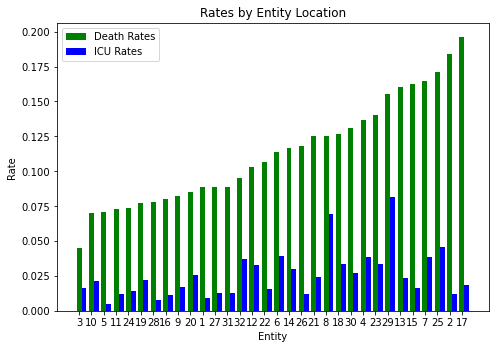

In [32]:
fig = plt.figure()
width = 0.4
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,len(list(sorted_entity_death_dict1.keys()))),list(sorted_entity_death_dict1.values()),width=width,color='green')
ax.bar(np.arange(0,len(list(sorted_entity_death_dict1.keys())))+width,ICU_entity_fill_ins1,width=width,color='blue')
ax.legend(('Death Rates','ICU Rates'))
plt.xticks(ticks=np.arange(0,len(list(sorted_entity_death_dict1.keys()))),labels=list(sorted_entity_death_dict1.keys()))
plt.title('Rates by Entity Location')
plt.xlabel('Entity')
plt.ylabel('Rate')
#plt.savefig('EDA/value_state.png',bbox_inches='tight')
plt.show()

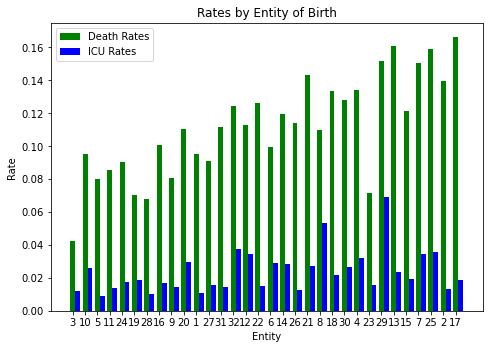

In [33]:
fig = plt.figure()
width = 0.4
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,len(list(sorted_entity_death_dict1.keys()))),death_entity_fill_ins2,width=width,color='green')
ax.bar(np.arange(0,len(list(sorted_entity_death_dict1.keys())))+width,ICU_entity_fill_ins2,width=width,color='blue')
ax.legend(('Death Rates','ICU Rates'))
plt.xticks(ticks=np.arange(0,len(list(sorted_entity_death_dict1.keys()))),labels=list(sorted_entity_death_dict1.keys()))
plt.title('Rates by Entity of Birth')
plt.xlabel('Entity')
plt.ylabel('Rate')
#plt.savefig('EDA/value_state.png',bbox_inches='tight')
plt.show()

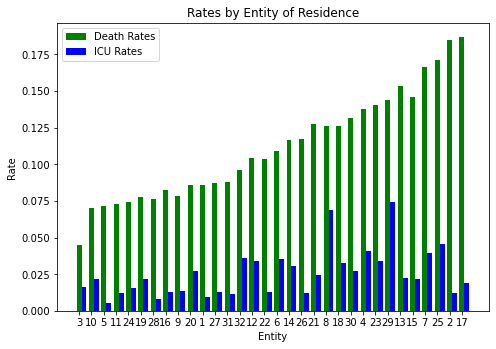

In [34]:
fig = plt.figure()
width = 0.4
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,len(list(sorted_entity_death_dict1.keys()))),death_entity_fill_ins3,width=width,color='green')
ax.bar(np.arange(0,len(list(sorted_entity_death_dict1.keys())))+width,ICU_entity_fill_ins3,width=width,color='blue')
ax.legend(('Death Rates','ICU Rates'))
plt.xticks(ticks=np.arange(0,len(list(sorted_entity_death_dict1.keys()))),labels=list(sorted_entity_death_dict1.keys()))
plt.title('Rates by Entity of Residence')
plt.xlabel('Entity')
plt.ylabel('Rate')
#plt.savefig('EDA/value_state.png',bbox_inches='tight')
plt.show()

The graphs for Entity Location and Entity of Residence both looks very similar. However, the graph for Entity of Birth doesn't look as similar to the other two graphs. Therefore, I will create supergroups for entities to be used in Entity Location and Entity of Residence. Then, I will create a separate supergroup for entities to be used in Entity of Birth.

##### Entity Super Group for Entity Location and Entity of Residence

In [35]:
#This entity_groupings1 dictionary will contain the mapping from entity to supergroup for entity location and entity of residence
#I picked 0.09 as the first cutoff because that roughly looks like the cutoff for the lowest third of the data
#I picked 0.13 as the second cutoff because that seems like the rough cutoff for the highest third of the data
entity_groupings1 = {}
for key in list(sorted_entity_death_dict1.keys()):
    if sorted_entity_death_dict1[key] < 0.09:
        entity_groupings1[int(key)] = 1
    elif 0.09 <= sorted_entity_death_dict1[key] <=0.13:
        entity_groupings1[int(key)] = 2
    else:
        entity_groupings1[int(key)] = 3

In [36]:
#now to map these definitions to the dataframe
entity_variables = ['Entity Location','Entity of Residence']
for var in entity_variables:
    print(var)
    new_column = []
    for i in range(len(covid_data[var])):
        current_entity = covid_data[var][i]
        if current_entity not in exclusion_values:
            new_column.append(entity_groupings1[current_entity])
        else:
            #I need to make it a 99 because otherwise np.nan will pop up lots of times in the np.unique when doing encoding.
            #Having a np.nan as 99 will be easier later than having it as either 97,98,or 99.
            new_column.append(99)
    covid_data[var+" Grouped"] = new_column

Entity Location
Entity of Residence


In [37]:
#now I need to encode these new grouped entity features
print('Entity Location')
entity_location_encoding = utils.encodeQualitative(covid_data['Entity Location Grouped'],'Entity',[99])
covid_data = pd.concat([covid_data,entity_location_encoding],axis=1)

print('Residence')
entity_of_residence_encoding = utils.encodeQualitative(covid_data['Entity of Residence Grouped'],'Residence',[99])
covid_data = pd.concat([covid_data,entity_of_residence_encoding],axis=1)

Entity Location
Residence


In [38]:
del death_entity_dict1 
del death_entity_dict2 
del death_entity_dict3 

del entity_subset1
del entity_subset2
del entity_subset3

del ICU_entity_dict1 
del ICU_entity_dict3 

del sorted_entity_death_dict1  
del sorted_entity_death_dict3 

del sorted_entity_ICU_dict1 
del sorted_entity_ICU_dict2 
del sorted_entity_ICU_dict3 

del ICU_entity_fill_ins1 
del ICU_entity_fill_ins2 
del ICU_entity_fill_ins3

del death_entity_fill_ins2 
del death_entity_fill_ins3

del new_column

del entity_location_encoding

del entity_of_residence_encoding

##### Entity Supergroup for Entity of Birth

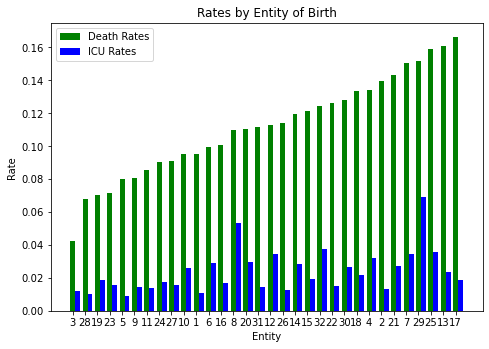

In [39]:
ICU_entitybirth_fill_ins2 = []
for k in list(sorted_entity_death_dict2.keys()):
    ICU_entitybirth_fill_ins2.append(ICU_entity_dict2[k])
    
fig = plt.figure()
width = 0.4
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,len(list(sorted_entity_death_dict2.keys()))),list(sorted_entity_death_dict2.values()),width=width,color='green')
ax.bar(np.arange(0,len(list(sorted_entity_death_dict2.keys())))+width,ICU_entitybirth_fill_ins2,width=width,color='blue')
ax.legend(('Death Rates','ICU Rates'))
plt.xticks(ticks=np.arange(0,len(list(sorted_entity_death_dict2.keys()))),labels=list(sorted_entity_death_dict2.keys()))
plt.title('Rates by Entity of Birth')
plt.xlabel('Entity')
plt.ylabel('Rate')
#plt.savefig('EDA/value_state.png',bbox_inches='tight')
plt.show()

In [40]:
#This entity_groupings2 dictionary will contain the mapping from entity to supergroup for entity of birth
#I picked 0.075 as the first cutoff because it seems like the rough cutoff for the lowest third of the data
#I picked 0.11 as the second cutof because it seems like the rought cutoff for the highest thrid of the data
entity_groupings2 = {}
for key in list(sorted_entity_death_dict2.keys()):
    if sorted_entity_death_dict2[key] < 0.075:
        entity_groupings2[int(key)] = 1
    elif 0.075 <= sorted_entity_death_dict2[key] <=0.11:
        entity_groupings2[int(key)] = 2
    else:
        entity_groupings2[int(key)] = 3

In [41]:
#now to map these definitions to the dataframe
entity_variables = ['Entity of Birth']
for var in entity_variables:
    print(var)
    new_column = []
    for i in range(len(covid_data[var])):
        current_entity = covid_data[var][i]
        if current_entity not in exclusion_values:
            new_column.append(entity_groupings2[current_entity])
        else:
            #I need to make it a 99 because otherwise np.nan will pop up lots of times in the np.unique when doing encoding.
            #Having a np.nan as 99 will be easier later than having it as either 97,98,or 99.
            new_column.append(99)
    covid_data[var+" Grouped"] = new_column

Entity of Birth


In [42]:
#now I need to encode these new grouped entity features and add them to the dataframe
print('Entity of Birth')
entity_of_birth_encoding = utils.encodeQualitative(covid_data['Entity of Birth Grouped'],'Birth',[99])
covid_data = pd.concat([covid_data,entity_of_birth_encoding],axis=1)

Entity of Birth


In [43]:
del new_column
del ICU_entity_dict2 
del sorted_entity_death_dict2
del ICU_entitybirth_fill_ins2
del entity_of_birth_encoding

In [44]:
#Also, now that the data cleaning is finished, the only observations left are those with "Prior Nationality" of Mexico, 
#giving this feature no variation so I am going to delete this (this might explain why there were all the N/A's, because
#since the patient was coming from another country, their information wasn't available to Mexico).
del covid_data['Prior Nationality']

In [45]:
#there are a few left over features that won't be necessary for analysis later on in the project, such as record ID and 
#submission date. Therefore, I will delete them before writing the cleaned data to a csv file
variables_to_delete = ['Update Date','Record ID','Admission Date','Sympton Onset','Date of Death']
for var in variables_to_delete:
    del covid_data[var]

### Writing the Final Cleaned Data to a CSV File

In [46]:
covid_data.to_csv('Data/CleanedCovidData10-12.csv')

### Creating an updated dictionary of value mappings for the cleaned data

In [47]:
clean_entity_dict = dict(zip(entity_numbers[:len(entity_numbers)-3],entity_names[:len(entity_names)-3]))
clean_nationality_dict = dict(zip([1,2],['Mexican','Foreign']))
clean_origin_dict = dict(zip([1,2],['Usmer','Not Usmer']))
clean_yes_no_dict = dict(zip([0,1],['No','Yes']))

In [48]:
clean_value_mapping_dict={
    'Update Date':{},
    'Record ID':{},
    'Origin':clean_origin_dict,
    'Sector':dict(zip([1,2,3,4,5,6,7,8,9,10,11,12,13],['Red Cross','DIF','State','IMSS','IMSS-Wellness','ISSSTE','Municipal','PEMEX','Private','SEDENA','SEMAR','SSA','Academic'])),
    'Entity Location':clean_entity_dict,
    'Sex':dict(zip([1,2],['Female','Male'])),
    'Entity of Birth':clean_entity_dict,
    'Entity of Residence':clean_entity_dict,
    'Type of Care':dict(zip([1,2],['Ambulatory','Hospitalized'])),
    'Admission Date':{},
    'Sympton Onset':{},
    'Date of Death':{},
    'Intubation Required':clean_yes_no_dict,
    'Pneumonia':clean_yes_no_dict,
    'Age':{},
    'Nationality':clean_nationality_dict,
    'Pregnant':clean_yes_no_dict,
    'Speak Indigenous':clean_yes_no_dict,
    'Diabetes':clean_yes_no_dict,
    'COPD Diagnosis':clean_yes_no_dict,
    'Asthma':clean_yes_no_dict,
    'Immunosuppression':clean_yes_no_dict,
    'Hypertension':clean_yes_no_dict,
    'Other Diseases':clean_yes_no_dict,
    'Cardiovascular Disease':clean_yes_no_dict,
    'Obesity':clean_yes_no_dict,
    'Kidney Failure':clean_yes_no_dict,
    'Smoker':clean_yes_no_dict,
    'Contact':clean_yes_no_dict,
    'Test Result':dict(zip([1],['Positive'])),
    'Migrant':clean_yes_no_dict,
    'Prior Nationality':{},
    'Prior Origin':{},
    'Intensive Care Needed':clean_yes_no_dict,
    'Entity Location Grouped':dict(zip([1,2,3],['Group 1','Group 2','Group 3'])),
    'Entity of Birth Grouped':dict(zip([1,2,3],['Group 1','Group 2','Group 3'])),
    'Entity Location Mapping':entity_groupings1,
    'Entity of Residence Mapping':entity_groupings1,
    'Entity of Birth Mapping':entity_groupings2
}

In [49]:
with open('Data/data_mapping_clean_data.json', 'w') as json_file:
    json.dump(clean_value_mapping_dict, json_file)